## Linear Discriminant Analysis

Linear Discriminant Analysis (LDA) is a feature transformation technique as well as a supervised classifier. It is commonly used as a preprocessing step for classification pipelines. The goal of LDA, like PCA, is to extract a new coordinate system and project datasets onto a lower-dimensional space. The main difference between LDA and PCA is that instead of focusing on the variance of the data as a whole like PCA, LDA optimizes the lower-dimensional space for the best class separability. This means that the new coordinate system is more useful in finding decision boundaries for classification models, which is perfect for us when building classification pipelines.

The reason that LDA is extremely useful is that separating based on class separability helps us avoid overfitting in our machine learning pipelines. This is also known as preventing the curse of dimensionality. LDA also reduces computational costs.

## How LDA works

LDA works as a dimensionality reduction tool, just like PCA, however instead of calculating the eigenvalues of the covariance matrix of the data as a whole, LDA calculates eigenvalues and eigenvectors of within-class and between-class scatter matrices. Performing LDA can be broken down into five steps:

1. Calculate mean vectors of each class

2. Calculate within-class and between-class scatter matrices

3. Calculate eigenvalues and eigenvectors for  $S^{-1}_WS_B$

4. Keep the top k eigenvectors by ordering them by descending eigenvalues

5. Use the top eigenvectors to project onto the new space

## Calculating the mean vectors of each class

First, we need to calculate a column-wise mean vector for each of our classes. One for setosa, one for versicolor, and another for virginica:

In [1]:
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()
X = iris.data
y = iris.target

In [2]:
label_dict = {i: k for i, k in enumerate(iris.target_names)}
# {0: 'setosasa', 1: 'versicolor', 2: 'virginica'}

def plot(X, y, title, x_label, y_label):
    ax = plt.subplot(111)
    for label, marker, color in zip(range(3), ('^', 's', 'o'), ('blue', 'red', 'green')):
        plt.scatter(x=X[:, 0].real[y == label],
                   y=X[:, 1].real[y == label],
                   color=color, alpha=0.5,
                   label=label_dict[label])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

In [3]:
# calculate the mean for each class
# to do this we will separate the iris dataset into three dataframes
# one for each flower, then we will take one's mean columnwise

mean_vectors = []
for cl in [0, 1, 2]:
    class_mean_vector = np.mean(X[y == cl], axis=0)
    mean_vectors.append(class_mean_vector)
    print(label_dict[cl], class_mean_vector)

setosa [5.006 3.418 1.464 0.244]
versicolor [5.936 2.77  4.26  1.326]
virginica [6.588 2.974 5.552 2.026]


## Calculating within-class and between-class scatter matrices

We will now calculate a within-class scatter matrix, defined by the following: $$S_W = \sum_{i=1}^cS_i$$

Where we define $S_i$ as: $$S_i = \sum_{x \in D_i}^n(x - m_i)(X - m_i)^T$$

Here, $m_i$ represents the mean vector for the i class, and a between-class scatter matrix defined by the following:
$$S_B = \sum_{i=1}^cN_i(m_i - m)(m_i - m)^T$$

$m$ is the overall mean of the dataset, $m_i$ is the sample mean for each class, and $N_i$ is the sample size for each class (number of observations per class):

In [7]:
# Calculate within-class scatter matrix
S_W = np.zeros((4, 4))
# for each flower
for cl, mv in zip([0, 1, 2], mean_vectors):
    # scatter matrix for every class, starts with all 0
    class_sc_mat = np.zeros((4, 4))
    # for each row that describes the specific flower
    for row in X[y == cl]:
        # make column vectors
        row, mv = row.reshape(4,1), mv.reshape(4, 1)
        # this ia a 4x4 matrix
        class_sc_mat += (row-mv).dot((row-mv).T)
    # sum class scatter matrices
    S_W += class_sc_mat

S_W

array([[38.9562, 13.683 , 24.614 ,  5.6556],
       [13.683 , 17.035 ,  8.12  ,  4.9132],
       [24.614 ,  8.12  , 27.22  ,  6.2536],
       [ 5.6556,  4.9132,  6.2536,  6.1756]])

In [9]:
# Calculate the between class scatter matrix

# mean of entire dataset
overall_mean = np.mean(X, axis=0).reshape(4, 1)

# will eventually become between class scatter matrix
S_B = np.zeros((4,4))
for i, mean_vec in enumerate(mean_vectors):
    # number of flowers in each species
    n = X[y==i, :].shape[0]
    # make column vector for each species
    mean_vec = mean_vec.reshape(4, 1)
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    
S_B

array([[ 63.21213333, -19.534     , 165.16466667,  71.36306667],
       [-19.534     ,  10.9776    , -56.0552    , -22.4924    ],
       [165.16466667, -56.0552    , 436.64373333, 186.90813333],
       [ 71.36306667, -22.4924    , 186.90813333,  80.60413333]])

Within-class and between-class scatter matrices are generalizations of a step in the ANOVA test (mentioned in the previous chapter). The idea here is to decompose our iris dataset into two distinct parts.

Once we have calculated these matrices, we can move onto the next step, which uses matrix algebra to extract linear discriminants.

## Calculating eigenvalues and eigenvectors for $S^{-1}_WS_B$ 
Just as we did in PCA, we rely on eigenvalue decompositions of a specific matrix. In the case of LDA, we will be decomposing the matrix $S^{-1}_WS_B$ :

In [10]:
# calculate eigenvalues and eigenvectors of S-1W X SB
eig_vals, eig_vecs = np.linalg.eig(np.dot(np.linalg.inv(S_W), S_B))
eig_vecs = eig_vecs.real
eig_vals = eig_vals.real

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i]
    print('Eigenvector {}: {}'.format(i + 1, eigvec_sc))
    print('Eigenvalue {} : {}'. format(i+1, eig_vals[i]))

Eigenvector 1: [ 0.20490976  0.38714331 -0.54648218 -0.71378517]
Eigenvalue 1 : 32.27195779972981
Eigenvector 2: [-0.00898234 -0.58899857  0.25428655 -0.76703217]
Eigenvalue 2 : 0.27756686384004514
Eigenvector 3: [ 0.26284129 -0.36351406 -0.41271318  0.62287111]
Eigenvalue 3 : -2.170668690724263e-15
Eigenvector 4: [ 0.26284129 -0.36351406 -0.41271318  0.62287111]
Eigenvalue 4 : -2.170668690724263e-15


Note that the third and fourth eigenvalues are basically zero. This is because the way LDA is trying to work is by drawing decision boundaries between our classes. Because we only have three classes in the iris, we may only draw up to two decision boundaries. In general, fitting LDA to a dataset with n classes will only produce up to n-1 components.

## Keeping the top k eigenvectors by ordering them by descending eigenvalues

As in PCA, we only wish to keep the eigenvectors that are doing most of the work:

In [11]:
# keep the top two linear discriminants
linear_discriminants = eig_vecs.T[:2] 
linear_discriminants

array([[ 0.20490976,  0.38714331, -0.54648218, -0.71378517],
       [-0.00898234, -0.58899857,  0.25428655, -0.76703217]])

We can look at the ratio of explained variance in each component/linear discriminant by dividing each eigenvalue by the sum total of all eigenvalues:

In [12]:
#explained variance ratios
eig_vals / eig_vals.sum()

array([ 9.91472476e-01,  8.52752434e-03, -6.66881840e-17, -6.66881840e-17])

It appears that the first component is doing a vast majority of the work and holding over 99% of the information on its own. 

## Using the top eigenvectors to project onto the new space
Now that we have our components, let's plot the projected iris data by first using the eigenvectors to project the original data onto the new space and then calling our plot function:

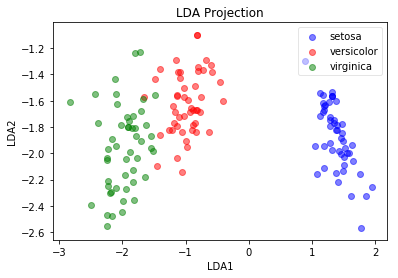

In [13]:
# LDA projected data
lda_iris_projection = np.dot(X, linear_discriminants.T)
lda_iris_projection[:5,]

plot(lda_iris_projection, y, "LDA Projection", "LDA1", "LDA2")

Notice that in this graph, the data is standing almost fully upright (even more than PCA projected data), as if the LDA components are trying to help machine learning models separate the flowers as much as possible by drawing these decision boundaries and providing eigenvectors/linear discriminants. This helps us project data into a space that separates classes as much as possible.

## How to use LDA in scikit-learn
LDA has an implementation in scikit-learn to avoid this very laborious process. It is easily imported:

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

From there, let's use it to fit and transform our original iris data and plot the resulting projected dataset so that we may compare it to the projection using PCA. The biggest thing to notice in the following code block is that the fit function requires two inputs.

Recall how we mentioned that LDA is actually a classifier disguised as a feature transformation algorithm. Unlike PCA, which finds components in an unsupervised manner (without a response variable), LDA will attempt to find the best coordinate system with respect to a response variable that optimizes for class separability. This implies that LDA only works if we have a response variable. If we do, we input the response as a second input to our fit method and let LDA do its thing:

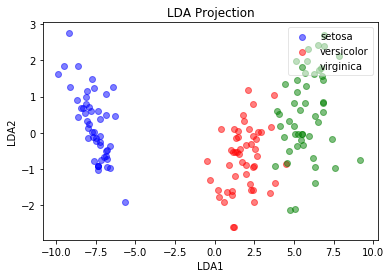

In [17]:
# instantiate the LDA module
lda = LinearDiscriminantAnalysis(n_components=2)
 
# fit and transform our original iris data
X_lda_iris = lda.fit_transform(X, y)
 
# plot the projected data
plot(X_lda_iris, y, "LDA Projection", "LDA1", "LDA2")

This graph is a mirror image of the manual LDA that we performed. This is OK. Recall in PCA that the manual version we had contained eigenvectors that had opposite signs (positive versus negative). This does not affect our machine learning pipelines. Within the LDA module, we have some differences to keep note of. Instead of a .components_ attribute, we have a .scalings_ attribute, which acts almost the same:

In [21]:
# essentially the same as pca.components_, but transposed (4x2 instead of 2x4)
lda.scalings_ 
#  array([[ 0.81926852, 0.03285975], [ 1.5478732 , 2.15471106], [-2.18494056, -0.93024679], [-2.85385002, 2.8060046 ]])

array([[-0.81926852,  0.03285975],
       [-1.5478732 ,  2.15471106],
       [ 2.18494056, -0.93024679],
       [ 2.85385002,  2.8060046 ]])

In [20]:
# same as manual calculations
lda.explained_variance_ratio_
# array([ 0.9915, 0.0085])

array([0.99147248, 0.00852752])

The explained variance ratios for the two linear discriminants are exactly the same as the ones we calculated before and notice that they omit the third and fourth eigenvalues because they are virtually zero.

These components, however, at first glance, look nothing like the manual eigenvectors that we achieved before. The reason for this is that the way that scikit-learn calculates the eigenvectors produces the same eigenvectors, but scaled by a scalar, as follows:

In [24]:
# show that the sklearn components are just a scalar multiplication from the manual components we calculateda
for manual_component, sklearn_component in zip(eig_vecs.T[:2], lda.scalings_.T):
    print(sklearn_component / manual_component)

[-3.99819178 -3.99819178 -3.99819178 -3.99819178]
[-3.65826194 -3.65826194 -3.65826194 -3.65826194]


The scikit-learn linear discriminants are a scalar multiplication of the manual eigenvectors, which means that they are both valid eigenvectors. The only difference is in the scaling of the projected data.

These components are organized as a 4 x 2 matrix, instead of the PCA components, which was given to us as a 2 x 4 matrix. This was a choice when developing the module and doesn't affect the math at all for us. LDA, like PCA, scales invariant, so scaling the data matters.

Let's fit the LDA module to scaled iris data and look at the components to see the difference:

In [29]:
from sklearn.preprocessing import StandardScaler

# doing a normal z score scaling
X_scaled = StandardScaler().fit_transform(X)
# fit our LDA to scaled data
X_lda_iris = lda.fit_transform(X_scaled, y)

lda.scalings_ # different scalings when data are scaled
 

array([[-0.67614337,  0.0271192 ],
       [-0.66890811,  0.93115101],
       [ 3.84228173, -1.63586613],
       [ 2.17067434,  2.13428251]])

The scalings_ attribute (akin to PCA's components_ attribute) is showing us different arrays, which means that the projection will also be different. To finish our (briefer) description of LDA, let's apply the same code block that we did with PCA and interpret the scalings_ arrays as we did with the components_ attribute of PCA.

Let's first fit and transform LDA on our truncated iris dataset, where we have only kept the first two features:

In [31]:
# cut our last two columns of the original iris dataset 
iris_2_dim = X[:, 2:4]

# center the data
iris_2_dim = iris_2_dim - iris_2_dim.mean(axis=0)

In [32]:
# fit our LDA to our truncated iris dataset
iris_2_dim_transformed_lda = lda.fit_transform(iris_2_dim, y)

Let's take a look at the first five rows of our projected dataset:

In [33]:
# project data
iris_2_dim_transformed_lda[:5,]

array([[-6.04248571,  0.07027756],
       [-6.04248571,  0.07027756],
       [-6.19690803,  0.28598813],
       [-5.88806338, -0.14543302],
       [-6.04248571,  0.07027756]])

Our scalings_ matrix is now a 2 x 2 matrix (2 rows and 2 columns) where the columns are the components (instead of the rows being components in PCA). To adjust for this, let's make a new variable called components that holds the transposed version of the scalings_ attribute:

In [34]:
# different notation
components = lda.scalings_.T # transposing gives same style as PCA. We want rows to be components
print(components)

[[ 1.54422328  2.40338224]
 [-2.15710573  5.02431491]]


In [35]:
 np.dot(iris_2_dim, components.T)[:5,] # same as transform method

array([[-6.04248571,  0.07027756],
       [-6.04248571,  0.07027756],
       [-6.19690803,  0.28598813],
       [-5.88806338, -0.14543302],
       [-6.04248571,  0.07027756]])

We can see that se uses the components variable in the same way that we did the PCA components_ attribute. This implies that the projection is another linear combination of original columns, just as they were in PCA. It is also worth noting that LDA still de-correlates features, just as PCA did. To show this, let us calculate the correlation coefficient matrix of both the original truncated iris data and the correlation matrix of the projected data:

In [36]:
# original features are highly correlated
np.corrcoef(iris_2_dim.T)

array([[1.       , 0.9627571],
       [0.9627571, 1.       ]])

In [38]:
# new LDA features are highly uncorrelated, like in PCA
np.corrcoef(iris_2_dim_transformed_lda.T)

array([[1.00000000e+00, 1.48769096e-15],
       [1.48769096e-15, 1.00000000e+00]])

Note that in the top right value in each matrix, the original matrix is showing highly correlated features, while the projected data using LDA has highly independent features (given the close to zero correlation coefficient). To wrap up our interpretation of LDA before we move onto the real fun (using both PCA and LDA for machine learning), let's take a look at a visualization of the scalings_ attribute of LDA, just as we did for PCA:

[(-3, 3),
 Text(0,0.5,'lda component 2'),
 (-10, 10),
 Text(0.5,0,'lda component 1'),
 Text(0.5,1,'Linear Discriminant Analysis Projected Data')]

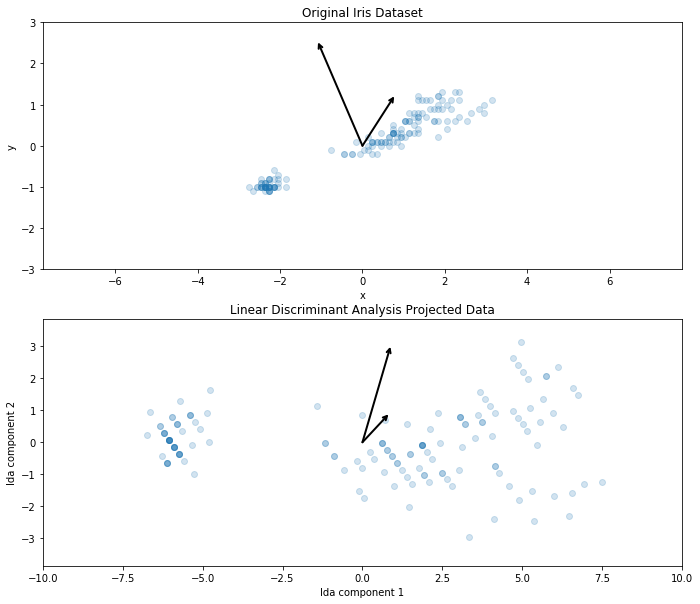

In [39]:
# This code is graphing both the original iris data and the projected version of it using LDA.
# Moreover, on each graph, the scalings of the LDA are graphed as vectors on the data themselves
# The longer of the arrows is meant to describe the first scaling vector and
# the shorter of the arrows describes the second scaling vector
def draw_vector(v0, v1, ax):
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(iris_2_dim[:, 0], iris_2_dim[:, 1], alpha=0.2)
for length, vector in zip(lda.explained_variance_ratio_, components):
    v = vector * .5
    draw_vector(lda.xbar_, lda.xbar_ + v, ax=ax[0])  # lda.xbar_ is equivalent to pca.mean_
ax[0].axis('equal')
ax[0].set(xlabel='x', ylabel='y', title='Original Iris Dataset',
         xlim=(-3, 3), ylim=(-3, 3))

ax[1].scatter(iris_2_dim_transformed_lda[:, 0], iris_2_dim_transformed_lda[:, 1], alpha=0.2)
for length, vector in zip(lda.explained_variance_ratio_, components):
    transformed_component = lda.transform([vector])[0]
    v = transformed_component * .1
    draw_vector(iris_2_dim_transformed_lda.mean(axis=0), iris_2_dim_transformed_lda.mean(axis=0) + v, ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='lda component 1', ylabel='lda component 2',
          title='Linear Discriminant Analysis Projected Data',
          xlim=(-10, 10), ylim=(-3, 3))

Notice how the component, instead of going with the variance of the data, goes almost perpendicular to it; it's following the separation of the classes instead. Also, note how it's almost parallel with the gap between the flowers on the left and right side. LDA is trying to capture the separation between classes

In the top graph, we can see the original iris dataset with the scalings_ vectors overlaid on top of the data-points. The longer vector is pointing almost parallel to the large gap between the setosas on the bottom left and the rest of the flowers on the top right. This is indicative that the LDA is trying to point out the best directions to look in to separate the classes of flowers in the original coordinate system.

It is important to note here that the scalings_ attribute of LDA does not correlate 1:1 to the new coordinate system as it did in PCA. This is because the goal of scalings_ is not to create a new coordinate system, but just to point in the direction of boundaries in the data that optimizes for class separability. We will not go into detail about the calculation of these new coordinate systems as we did with PCA. It is sufficient to understand that the main difference between PCA and LDA is that PCA is an unsupervised method that captures the variance of the data as a whole whereas LDA, a supervised method, uses the response variable to capture class separability.

Limitations of supervised feature transformations like LDA mean that they cannot help with tasks such as clustering, whereas PCA can help. This is because clustering is an unsupervised task and does not have a response variable for LDA to use.